In [71]:
import pandas as pd
date = 'non_peak_7_we'
dfj = pd.read_csv(f'./data/panel/{date}.csv')

In [73]:
import os
import numpy as np
import pandas as pd
import shap
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# 定义目录路径
plot_dir = './variable/plot/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# 加载数据
merged_df = dfj

# 删除 'bike-sharing usage' 为0的行
merged_df = merged_df[merged_df['bike-sharing usage'] > 0]

# 计算 log_bike-sharing usage 列
merged_df['log-biking-usage'] = np.log(merged_df['bike-sharing usage'])

# 定义自变量
X = merged_df[['Tmrt','POI diversity','road density', 'building density', 'bus distance', 
               'metro distance', 'BVI', 'SVI', 'GVI', 'VNMI', 'VHI', 
               'slope','NDVI','AQI']]

# 标准化自变量
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
X_standardized = pd.DataFrame(X_standardized, columns=X.columns)

# 定义因变量
y = merged_df['log-biking-usage']

# 训练 XGBoost 模型
model = XGBRegressor(n_estimators=20, random_state=42)
model.fit(X_standardized, y)

# 预测
y_pred = model.predict(X_standardized)

# 计算性能指标
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# 输出性能指标
print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

# 计算 SHAP 值
explainer = shap.Explainer(model)
shap_values = explainer(X_standardized)

# 计算 SHAP 重要性
shap_values_array = shap_values.values
shap_sum = np.abs(shap_values_array).mean(axis=0)

# 生成 SHAP 重要性 DataFrame
importance_df = pd.DataFrame(list(zip(X.columns, shap_sum)), columns=['Variable', 'SHAP Importance'])

# 添加 rank 列（按重要性从高到低排序）
importance_df['Rank'] = importance_df['SHAP Importance'].rank(ascending=False)

# 按给定特征顺序进行排序
order = [
    'Tmrt', 'POI diversity', 'road density', 'building density', 
    'bus distance', 'metro distance', 'slope', 'NDVI', 'AQI',
    'BVI', 'SVI', 'GVI', 'VNMI', 'VHI'
]
importance_df['Sort Order'] = importance_df['Variable'].map({v: i for i, v in enumerate(order)})
importance_df = importance_df.sort_values(by='Sort Order').drop(columns=['Sort Order'])

# # # 保存结果
# output_dir = './data/XAI_output/'
# os.makedirs(output_dir, exist_ok=True)
# importance_df.to_csv(f'{output_dir}/{date}.csv', index=False)

# 输出重要性排名
print("\nFeature Importance:")
print(importance_df)


Mean Squared Error: 0.4143
R^2 Score: 0.8655

Feature Importance:
            Variable  SHAP Importance  Rank
0               Tmrt         0.657615   1.0
1      POI diversity         0.374813   2.0
2       road density         0.108937   6.0
3   building density         0.041862  13.0
4       bus distance         0.320714   3.0
5     metro distance         0.127761   5.0
11             slope         0.070852   9.0
12              NDVI         0.169934   4.0
13               AQI         0.086670   7.0
6                BVI         0.085708   8.0
7                SVI         0.042529  12.0
8                GVI         0.043277  11.0
9               VNMI         0.061228  10.0
10               VHI         0.040124  14.0


/var/folders/20/nvll_17n0v95fpjp0d47qmz80000gn/T/ipykernel_1094/3256481328.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['log-biking-usage'] = np.log(merged_df['bike-sharing usage'])


In [75]:
# shap.summary_plot(shap_values, X_standardized, plot_type="bar", show=False)
# plt.gcf().set_size_inches(6, 10)  # 设置图像大小
# plt.gca().set_facecolor('white')
# plt.title('Global features importance in spring', fontsize=16, fontname='Times New Roman')
# plt.xticks(fontsize=18, fontname='Times New Roman')  # 设置x轴刻度字体大小
# plt.yticks(fontsize=18, fontname='Times New Roman')  # 设置y轴刻度字体大小
# plt.savefig(os.path.join(f'../resub_fig/XAI/bar_{date}.png'), bbox_inches='tight', dpi=300)

In [77]:
# shap.summary_plot(shap_values, X_standardized, show=False)
# plt.gcf().set_size_inches(6, 10)
# plt.gca().set_facecolor('white')
# plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
# plt.title('Global features importance in spring', fontsize=16, fontname='Times New Roman')
# plt.xticks(fontsize=18, fontname='Times New Roman')  # 设置x轴刻度字体大小
# plt.yticks(fontsize=18, fontname='Times New Roman')  # 设置y轴刻度字体大小
# plt.savefig(os.path.join(f'../resub_fig/XAI/sum_{date}.png'), bbox_inches='tight', dpi=300)

In [79]:
explainer = shap.TreeExplainer(model)
shap_interaction = explainer.shap_interaction_values(X_standardized)
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X_standardized.columns,columns=X_standardized.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

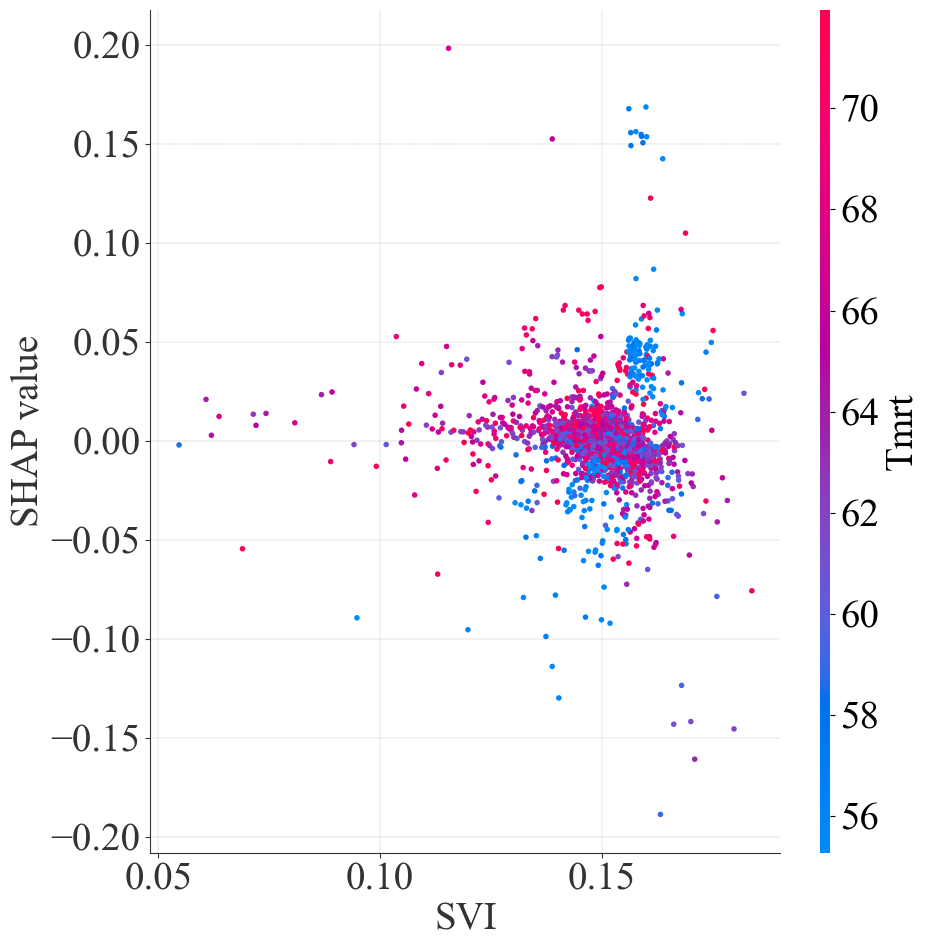

In [65]:
import shap
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24

fig, ax = plt.subplots(figsize=(10, 10))

factor = "SVI"
ax.grid(True, color='black', which='both', linestyle='--', linewidth=0.1)
# 生成SHAP依赖图
# ax.set_xlim(0, 0.6)
shap.dependence_plot(
    (factor, "Tmrt"),
    shap_interaction, X,
    display_features=X,
    ax=ax,
    show=False
)
ax.tick_params(labelsize=28)
ax.set_xlabel(factor, fontsize=28)  # Set the X label with the factor name
ax.set_ylabel("SHAP value", fontsize=28)  # Set Y label (customize as needed)
# 添加网格线
# ax.grid(True)
colorbar = ax.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(28)
colorbar.ax.tick_params(labelsize=28) 
# 确保图像布局没有被裁剪
plt.tight_layout()
plt.savefig(f'../resub_fig/XAI/{date}_interaction_{factor}.png', dpi=300)

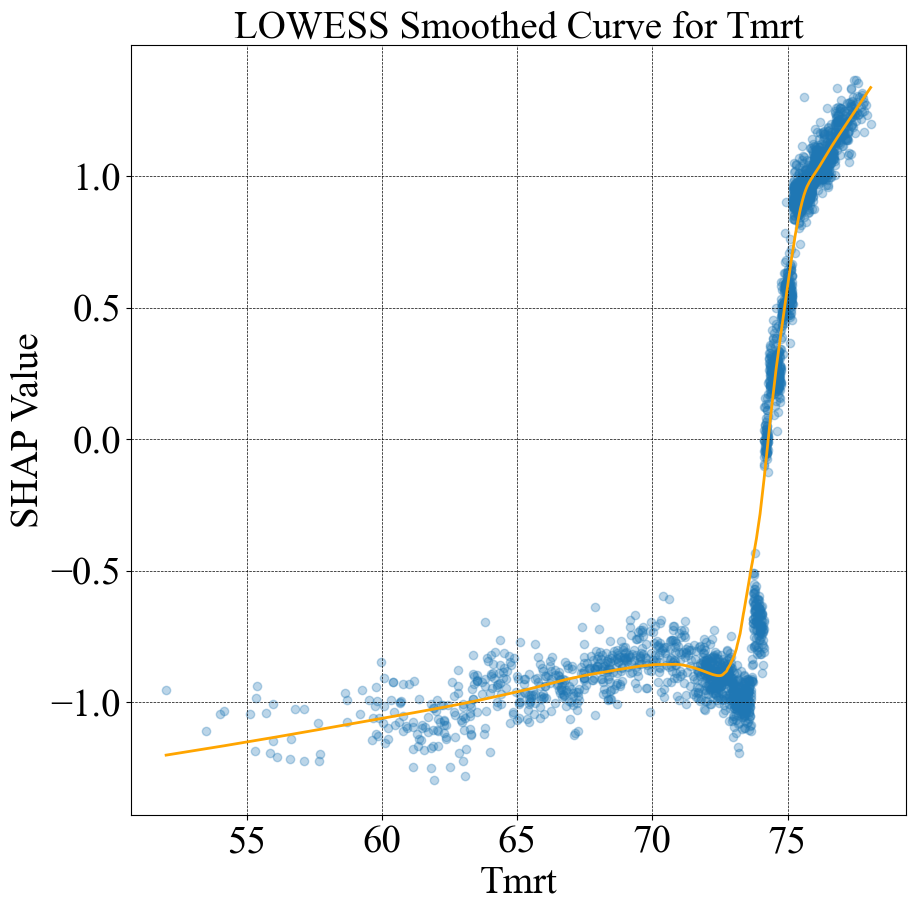

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 假设 shap_interaction 和 X 已经存在
# factor 是你要分析的特征名，例如 "Tmrt"

factor = "Tmrt"
# 提取特征值和对应的 SHAP 值
x_data = X[factor]
y_data = shap_interaction[:, X.columns.get_loc(factor), X.columns.get_loc(factor)]

# 使用 LOWESS 进行局部加权回归平滑
lowess = sm.nonparametric.lowess
z = lowess(y_data, x_data, frac=0.3)  # frac 是平滑参数，可以根据需要调整

# 提取平滑曲线的数据点
x_fit = z[:, 0]
y_fit = z[:, 1]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 30
# 绘制图形
fig, ax = plt.subplots(figsize=(10, 10))

# 设置背景颜色
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# 绘制数据点
ax.scatter(x_data, y_data, alpha=0.3, label='Data Points')

# 绘制 LOWESS 平滑曲线
ax.plot(x_fit, y_fit, color='orange', linestyle='-', linewidth=2, label='LOWESS Smoothed Curve')

# 设置网格和坐标轴颜色
ax.grid(True, color='black', linestyle='--', linewidth=0.5)
# ax.spines['top'].set_color('black')
# ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

ax.tick_params(axis='x', colors='black', labelsize=28)
ax.tick_params(axis='y', colors='black', labelsize=28)

# 设置图形标题和标签
ax.set_title(f'LOWESS Smoothed Curve for {factor}', color='black',fontsize = 28)
ax.set_xlabel(factor, color='black',fontsize = 28)
ax.set_ylabel('SHAP Value', color='black',fontsize = 28)
# ax.legend()

# 保存图像（可选）
plt.savefig(f'../resub_fig/XAI/{date}_lowess_curve_{factor}.png', dpi=300)  # 你可以调整dpi值以获得更高质量的图像
